In [17]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from matplotlib.colors import ListedColormap
from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np

from mlxtend.plotting import plot_confusion_matrix

## First steps with scikit-learn

### Training a perceptron via scikit-learn

In [3]:
iris = datasets.load_iris()

In [4]:
print(iris.DESCR)

Iris Plants Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20  0.76     0.9565  (high!)
    ============== ==== ==== ======= ===== ====================

    :Missing Attribute Values: None
  

In [5]:
X = iris.data[:, [2, 3]]
y = iris.target

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0, stratify=y)

In [7]:
std = StandardScaler().fit(X_train)

X_train_std = std.transform(X_train)
X_test_std = std.transform(X_test)

In [9]:
ppn = Perceptron(max_iter=40, eta0=.1, random_state=0).fit(X_train_std, y_train)

In [10]:
y_pred = ppn.predict(X_test_std)

$$precision = \frac{tp}{tp+fp}$$
$$recall = \frac{tp}{tp+fn}$$

In [15]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       1.00      0.93      0.97        15
          1       0.83      1.00      0.91        15
          2       1.00      0.87      0.93        15

avg / total       0.94      0.93      0.93        45



In [16]:
accuracy_score(y_test, y_pred)

0.93333333333333335

(<matplotlib.figure.Figure at 0x7fcb83a7aac8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fcb837ff048>)

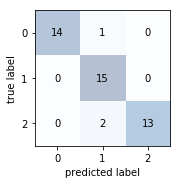

In [18]:
plot_confusion_matrix(conf_mat=confusion_matrix(y_test, y_pred))

In [21]:
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=.2, ax=None):
    
    markers = ('^', 'x', 'o', '^', 'v')
    colors = ('r', 'b', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
    
    z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    z = z.reshape(xx1.shape)
    
    if not ax:
        
        fig = plt.figure(figsize=(6, 6))
        ax = fig.add_subplot(111)
    
    ax.contourf(xx1, xx2, z, alpha=.4, cmap=cmap)
    ax.set_xlim(xx1.min(), xx1.max())
    ax.set_ylim(xx2.min(), xx2.max())
    
    for idx, cl in enumerate(np.unique(y)):
        
        ax.scatter(x=X[y == cl, 0], y=X[y == cl, 1], alpha=.8, c=cmap(idx), marker=markers[idx], label=cl)
        
    if test_idx is not None:
        
        X_test, y_test = X[test_idx, :], y[test_idx]
        ax.scatter(X_test[:, 0], X_test[:, 1], c='',\
                    alpha=1., linewidths=1, marker='o',\
                    s=55, label='test set')

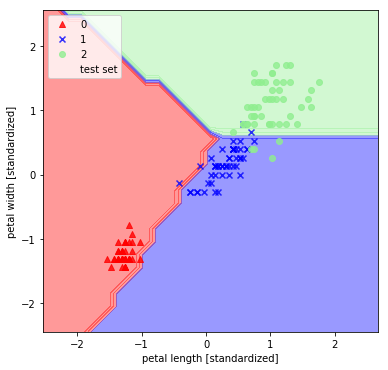

In [22]:
X_std = np.r_[X_train_std, X_test_std]
y_std = np.r_[y_train, y_test]

plot_decision_regions(X_std, y_std, ppn, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.gca().set_aspect('equal')

## Modeling class probabilities via logistic regression

### Logistic regression intuition and conditional probabilities

#### Sigmoid function

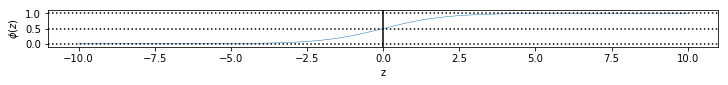

In [35]:
sigmoid = lambda z: 1. / (1. + np.exp(-z))
z = np.arange(-10, 10, .01)
phi_z = sigmoid(z)

plt.figure(figsize=(12, 6))
plt.plot(z, phi_z, linewidth=.5)
plt.axvline(.0, color='k') # vertical line
plt.axhline(.0, ls='dotted', color='k') # horizontal line
plt.axhline(.5, ls='dotted', color='k') # horizontal line
plt.axhline(1., ls='dotted', color='k') # horizontal line
plt.yticks([.0, .5, 1.])
plt.ylim(-.1, 1.1)
plt.xlabel('z')
plt.ylabel('$\phi (z)$')
plt.gca().set_aspect('equal')

In [46]:
lr = LogisticRegression(C=1000, random_state=0).fit(X_train_std, y_train)

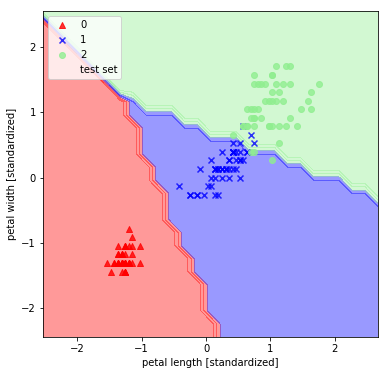

In [47]:
plot_decision_regions(X_std, y_std, lr, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')

## Tackling overfitting via regularization

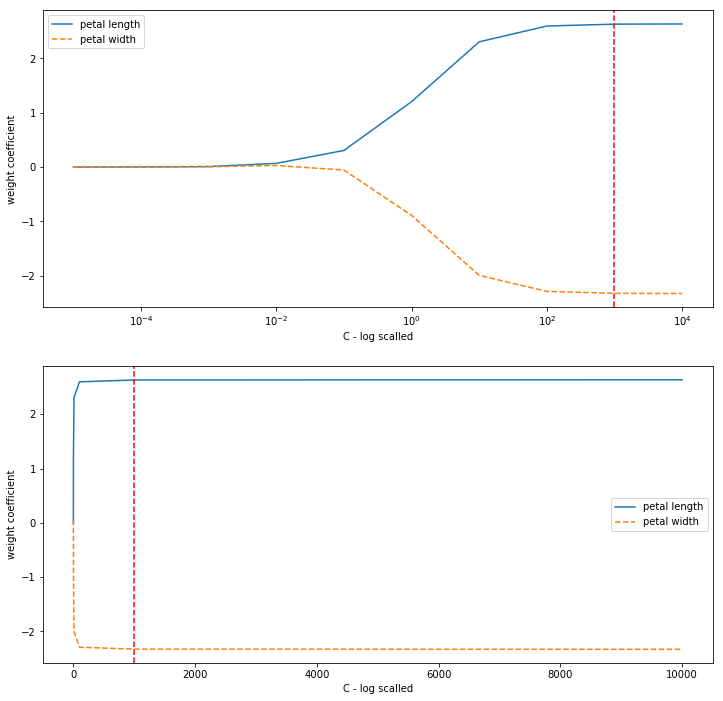

In [48]:
weights, params = [], []

for C in 10.**np.arange(-5, 5):

    lr = LogisticRegression(C=C, random_state=0).fit(X_train_std, y_train)
    weights.append(lr.coef_[1]) # coefs da classe 1, em esquema One Vs All
    params.append(C)
    
weights = np.array(weights)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

ax1.plot(params, weights[:, 0], label='petal length')
ax1.plot(params, weights[:, 1], label='petal width', linestyle='--')
ax1.set_ylabel('weight coefficient')
ax1.set_xlabel('C - log scalled')
ax1.legend(loc='upper left')
ax1.set_xscale('log')

# como interpretar esses gráficos com eixos em escalas não lineares?!
ax1.axvline(1000., linestyle='--', color='r')

ax2.plot(params, weights[:, 0], label='petal length')
ax2.plot(params, weights[:, 1], label='petal width', linestyle='--')
ax2.set_ylabel('weight coefficient')
ax2.set_xlabel('C - log scalled')
ax2.legend(loc='center right')
ax2.axvline(1000., linestyle='--', color='r')

## Maximum margin classification with support vector machines

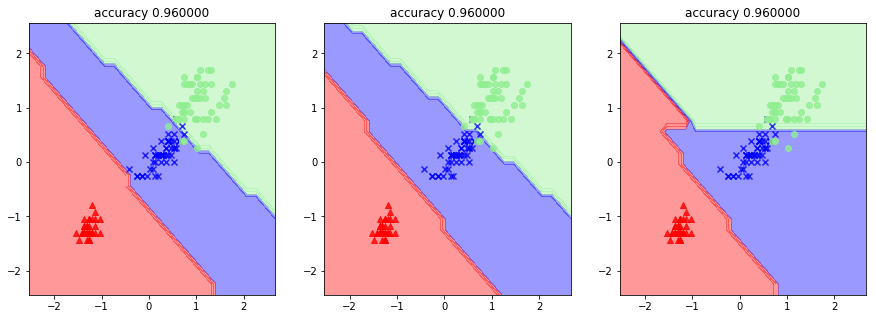

In [100]:
svm1 = SVC(kernel='linear', C=.001, random_state=10).fit(X_train_std, y_train)
svm2 = SVC(kernel='linear', C=.04, random_state=20).fit(X_train_std, y_train)
svm3 = SVC(kernel='linear', C=10., random_state=30).fit(X_train_std, y_train)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

plot_decision_regions(X_std, y_std, svm1, test_idx=range(105, 150), ax=ax1)
plot_decision_regions(X_std, y_std, svm2, test_idx=range(105, 150), ax=ax2)
plot_decision_regions(X_std, y_std, svm3, test_idx=range(105, 150), ax=ax3)

ax1.set_title('accuracy %f' % svm1.score(X_std, y_std))
ax2.set_title('accuracy %f' % svm2.score(X_std, y_std))
ax3.set_title('accuracy %f' % svm3.score(X_std, y_std))

## Alternative implementations in scikit-learn

In [57]:
from sklearn.linear_model import SGDClassifier

#### como comparar?

In [59]:
%timeit lr = SGDClassifier(loss='log', random_state=0, alpha=10, max_iter=100).fit(X_train_std, y_train)

4.18 ms ± 11.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [60]:
%timeit lr = LogisticRegression(C=1/10, random_state=0, max_iter=100).fit(X_train_std, y_train)

436 µs ± 1.84 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Solving nonlinear problems using a kernel SVM

In [61]:
random_state = np.random.RandomState(0)

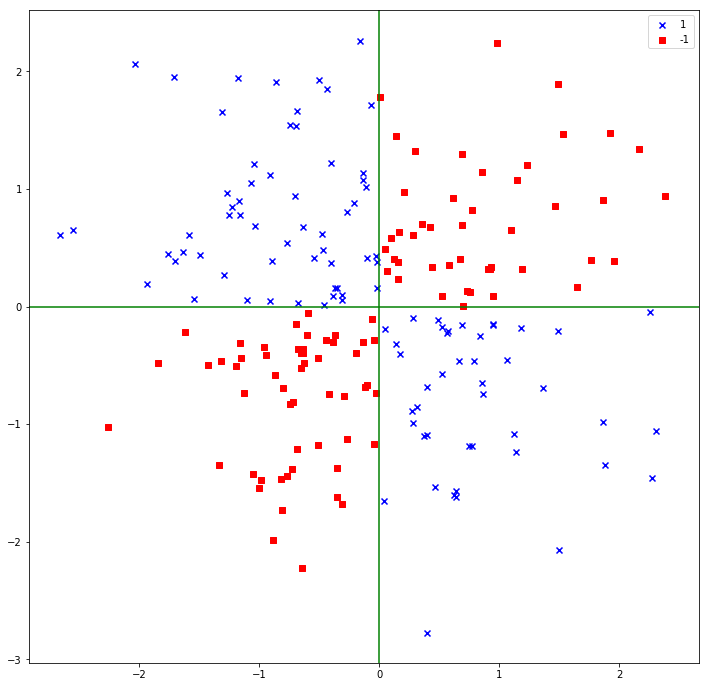

In [62]:
X_xor = random_state.randn(200, 2)
y_xor = np.logical_xor(X_xor[:, 0] > 0, X_xor[:, 1] > 0)
y_xor = np.where(y_xor, 1, -1)

plt.figure(figsize=(12, 12))
plt.scatter(X_xor[y_xor==1, 0], X_xor[y_xor==1, 1], c='b', marker='x', label='1')
plt.scatter(X_xor[y_xor==-1, 0], X_xor[y_xor==-1, 1], c='r', marker='s', label='-1')
plt.axhline(.0, color='g')
plt.axvline(.0, color='g')
plt.legend()

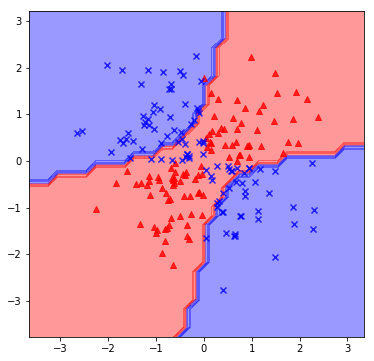

In [63]:
svm = SVC(kernel='rbf', random_state=0, gamma=.1, C=1.).fit(X_xor, y_xor)

plot_decision_regions(X_xor, y_xor, svm)

### usando dataset com features X[0], X[1] e X[0]*X[1], e plotando no plano X[0] X[1]

In [64]:
X_xor_on_roids = np.c_[X_xor, X_xor[:, 0] * X_xor[:, 1]]

In [65]:
# alterando a função de plot para apresentar os dados em X[0] e X[1]
# com modelo treinado em X[0], X[1] e X[0]*X[1]
def plot_decision_regions_on_roids(X, y, classifier, test_idx=None, resolution=.2, ax=None):
    
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('r', 'b', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    # grid X[0] X[1]
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
    # valor de X[0] * X[1] para a grid
    xx3 = xx1 * xx2
    
    xx = np.array([xx1.ravel(), xx2.ravel(), xx3.ravel()])
    
    z = classifier.predict(xx.T)
    z = z.reshape(xx1.shape)
    
    plt.contourf(xx1, xx2, z, alpha=.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    for idx, cl in enumerate(np.unique(y)):
        
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1], alpha=.8, c=cmap(idx), marker=markers[idx], label=cl)
        
    if test_idx is not None:
        
        X_test, y_test = X[test_idx, :], y[test_idx]
        plt.scatter(X_test[:, 0], X_test[:, 1], c='',\
                    alpha=1., linewidths=1, marker='o',\
                    s=55, label='test set')

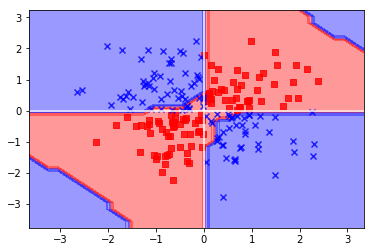

In [102]:
svm = SVC(kernel='rbf', random_state=0, gamma=.1, C=.1).fit(X_xor_on_roids, y_xor)

plot_decision_regions_on_roids(X_xor, y_xor, svm)
plt.axvline(.0, color='w')
plt.axhline(.0, color='w')

## Decision tree learning

Gini: $2p(1-p)$

Entropy: $-1 p\log_{2}(p) - (1-p)\log_{2}(1-p)$

In [73]:
gini = lambda p: 2 * p * (1 - p)
entropy = lambda p: -1 * p * np.log2(p) - (1 - p) * np.log2(1 - p)
error = lambda p: 1 - np.max(np.c_[p, 1 - p], axis=1)

x = np.arange(.0001, 1., .001)

ent = entropy(x)
sc_ent = ent * .5
err = error(x)
gin = gini(x)

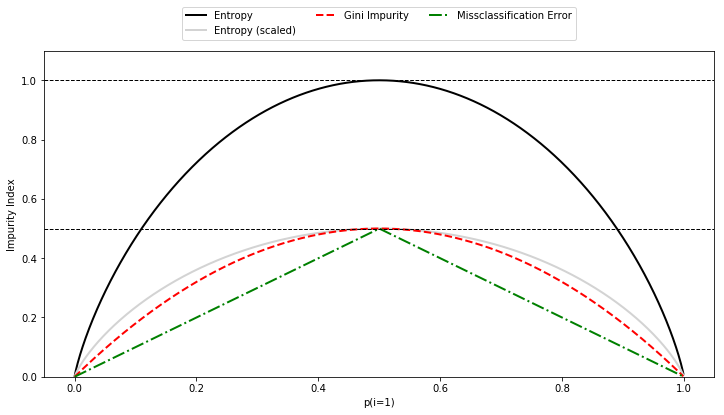

In [78]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.plot(x, ent, label='Entropy', linestyle='-', lw=2, color='black')
ax.plot(x, sc_ent, label='Entropy (scaled)', linestyle='-', lw=2, color='lightgray')
ax.plot(x, gin, label='Gini Impurity', linestyle='--', lw=2, color='red')
ax.plot(x, err, label='Missclassification Error', linestyle='-.', lw=2, color='green')

ax.legend(loc='upper center', bbox_to_anchor=(.5, 1.15), ncol=3, fancybox=True, shadow=False)

ax.axhline(.5, linewidth=1, color='k', linestyle='--')
ax.axhline(1., linewidth=1, color='k', linestyle='--')

plt.ylim([0, 1.1])
plt.xlabel('p(i=1)')
plt.ylabel('Impurity Index')

### Building a decision tree

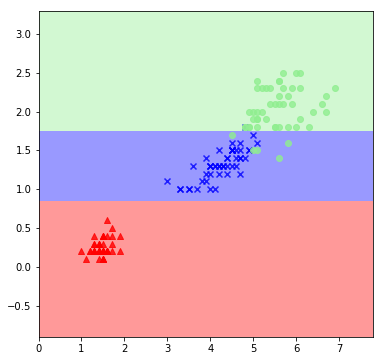

In [85]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0).fit(X_train, y_train)

plot_decision_regions(X, y, tree)

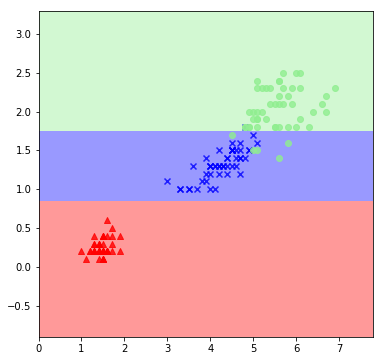

In [84]:
tree = DecisionTreeClassifier(criterion='gini', max_depth=2, random_state=0).fit(X_train, y_train)

plot_decision_regions(X, y, tree)

### Combining weak to strong learners via random forests

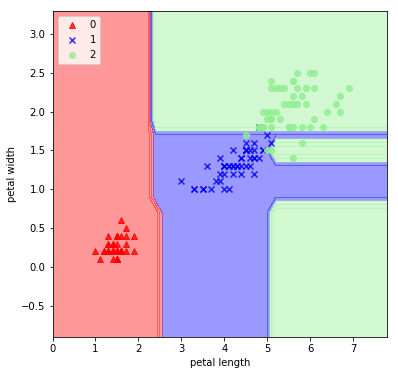

In [87]:
forest = RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=1, n_jobs=2).fit(X_train, y_train)

plot_decision_regions(X, y, forest)
plt.xlabel('petal length')
plt.ylabel('petal width')
plt.legend(loc='upper left')

## K-nearest neighbors - a lazy learning algorithm

#### minkowski

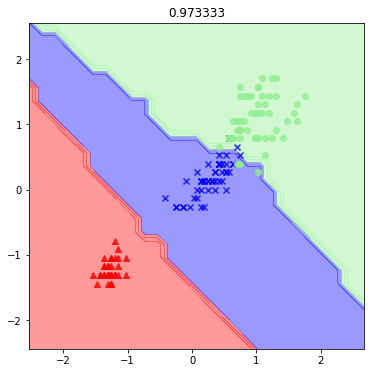

In [88]:
knn2 = KNeighborsClassifier(n_neighbors=5, metric='euclidean').fit(X_train_std, y_train)

plot_decision_regions(X_std, y_std, knn2, test_idx=range(105, 150))
plt.title('%f' % knn2.score(X_std, y_std))

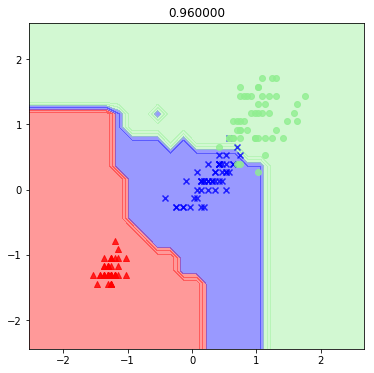

In [98]:
knn2 = KNeighborsClassifier(n_neighbors=5, metric='manhattan').fit(X_train_std, y_train)

plot_decision_regions(X_std, y_std, knn2, test_idx=range(105, 150))
plt.title('%f' % knn2.score(X_std, y_std))